## Import 

In [1]:
#!pip install pytorch-forecasting

In [2]:
from pathlib import Path
import sys
import os

ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
from hijri_converter import convert, Gregorian
#from xgboost import XGBRegressor
#from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from xgboost import plot_importance
#from decimal import Decimal
#from sklearn.inspection import permutation_importance
import joblib
from scripts.features_utils import get_features_tft, r2_score_real, get_data

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer


C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Pull the data
Take the same aggregation level than the previous model, passengers of one route aggregated by service date.

In [3]:
# pull the data. the aggregation data is per day
data = get_data()

if data is None:
    #there was an error fetching the data. exiting
    sys.exit("Couldn't open data from database or file. Aborting.")

In [4]:
data.columns

Index(['corridor_name', 'train_year', 'train_week_num',
       'train_departure_date_short', 'passengers', 'number_of_services',
       'revenue', 'revenue_without_promotion', 'passengers_km', 'seats_km',
       'day_category', 'price_mix_ratio', 'tickets_saudi', 'tickets_egyptian',
       'tickets_pakistani', 'tickets_indian', 'tickets_yemeni',
       'tickets_indonesian', 'tickets_jordanian', 'tickets_USA',
       'tickets_britain', 'residents', 'non_residents'],
      dtype='object')

In [5]:
# explore the data
data.head()

,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,seats_km,...,tickets_egyptian,tickets_pakistani,tickets_indian,tickets_yemeni,tickets_indonesian,tickets_jordanian,tickets_USA,tickets_britain,residents,non_residents
0,MAK-MAD,2021,53,2022-01-01,2579,12,419576.00,451077.0000,960687.672,2240230.752,...,156,56,84,51,13,41,108,24,1476,832
1,MAK-MAD,2022,1,2022-01-02,2038,12,343511.50,374778.0000,771785.126,2240230.752,...,112,40,59,51,15,55,58,34,674,667
2,MAK-MAD,2022,1,2022-01-03,1900,12,320459.00,345114.5000,730788.374,2240230.752,...,97,40,39,58,10,59,65,36,451,306
3,MAK-MAD,2022,1,2022-01-04,1810,12,306953.00,329255.0000,674187.758,2240230.752,...,85,46,40,34,4,14,45,41,348,129
4,MAK-MAD,2022,1,2022-01-05,2440,14,395531.00,422114.0000,936571.790,2613602.544,...,121,70,40,71,19,12,99,48,318,111


## Plot the original data

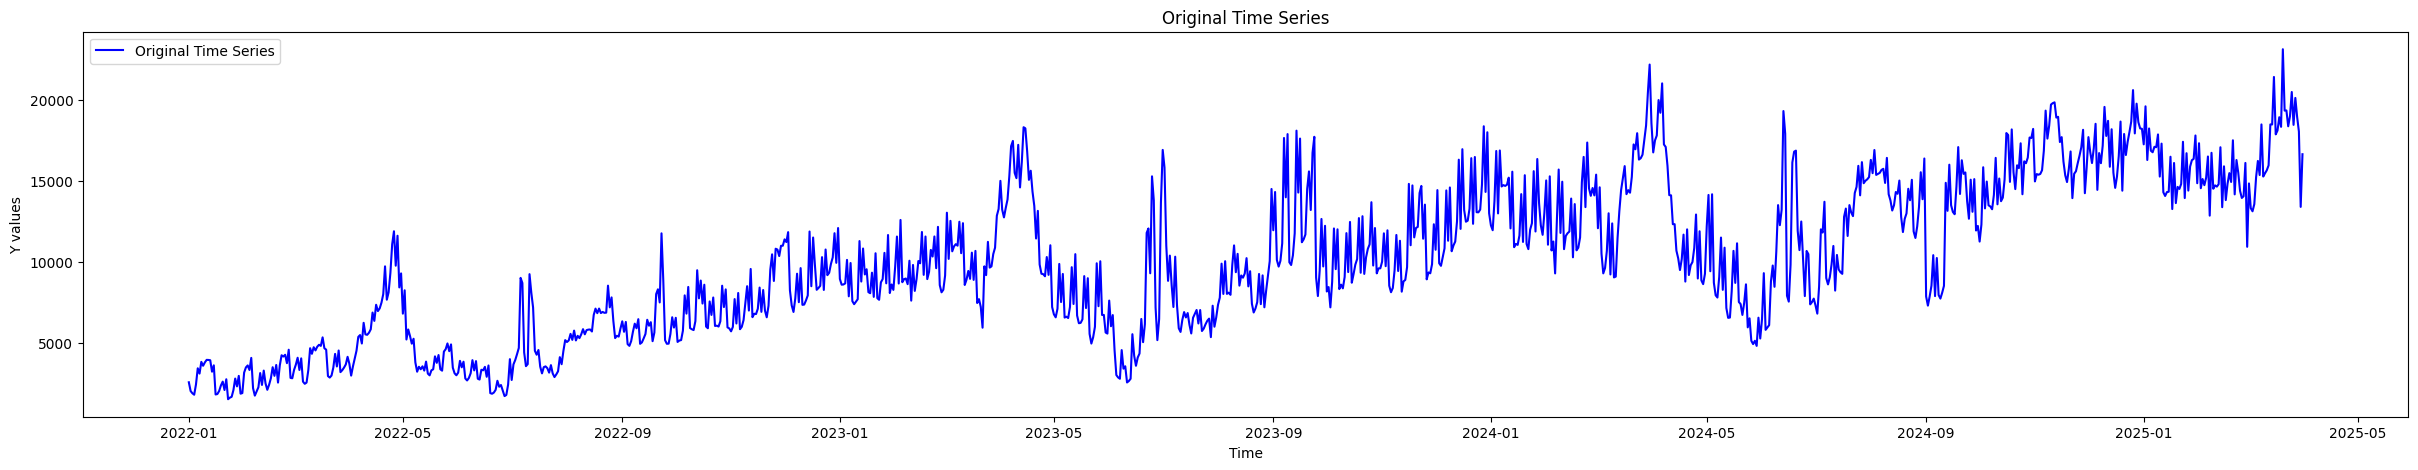

In [6]:
# load data
data.sort_values('train_departure_date_short', inplace=True)
data["train_departure_date_short"] = pd.to_datetime(data["train_departure_date_short"])
data = data[data["corridor_name"]=="MAK-MAD"]

# Plot the original time series
plt.figure(figsize=(30, 5))
plt.plot(data["train_departure_date_short"], data["passengers"], label="Original Time Series", color="blue")
plt.xlabel("Time")
plt.ylabel("Y values")
plt.title("Original Time Series")
plt.legend()
plt.show()


In [7]:
data.shape

(1186, 23)

## Prepare the features

In [8]:
# create the features

import pandas as pd

def gregorian_to_hijri(g_date):
    return convert.Gregorian(g_date.year, g_date.month, g_date.day).to_hijri()


#df = get_features_tft(data)
df  = data
# conversions
df['train_departure_date_short'] = pd.to_datetime(df['train_departure_date_short'])
df['passengers'] = df['passengers'].astype(float)
df['week_day'] = df['train_departure_date_short'].dt.day_name()
df['week_day'] = (df['week_day']).astype("category")
df['train_week_num'] = df['train_week_num'].astype(str).astype("category")
df['corridor_name'] = df['corridor_name'].astype("category")

# prices
df['price_ratio'] = (df['revenue'] / df['revenue_without_promotion']).astype(float)
df['price_mix_ratio'] = df['price_mix_ratio'].astype(float)

# timing
df = df.sort_values("train_departure_date_short")
df["time_idx"] = (df["train_departure_date_short"] - df["train_departure_date_short"].min()).dt.days
df['train_year'] = df['train_year'] - min(df['train_year'])
df["day_of_year"] = df["train_departure_date_short"].dt.dayofyear.clip(upper=365).astype(str).astype("category")
df["hijri_date"] = df["train_departure_date_short"].apply(gregorian_to_hijri)
df["hijri_day_of_year"] = df["hijri_date"].apply(lambda x: x.day).astype(str).astype("category")

# rolling average
df['rolling6'] = df['passengers'].astype(float).rolling(6).mean()
df.dropna(inplace=True)

#deal with unknown categories in the validations set
day_cutoff = "2024-08-01"
know_categories = df['day_category'][df['train_departure_date_short']<"2024-08-01"].unique()
df['day_category'] = df['day_category'].apply(lambda x: x if x in know_categories else "Autumn")
df['day_category'] = df['day_category'].astype('category')


In [9]:
df.columns.to_list()

['corridor_name',
 'train_year',
 'train_week_num',
 'train_departure_date_short',
 'passengers',
 'number_of_services',
 'revenue',
 'revenue_without_promotion',
 'passengers_km',
 'seats_km',
 'day_category',
 'price_mix_ratio',
 'tickets_saudi',
 'tickets_egyptian',
 'tickets_pakistani',
 'tickets_indian',
 'tickets_yemeni',
 'tickets_indonesian',
 'tickets_jordanian',
 'tickets_USA',
 'tickets_britain',
 'residents',
 'non_residents',
 'week_day',
 'price_ratio',
 'time_idx',
 'day_of_year',
 'hijri_date',
 'hijri_day_of_year',
 'rolling6']

## Training

In [107]:
from pytorch_forecasting import TimeSeriesDataSet, NaNLabelEncoder

training_cutoff = "2024-08-01"
prediction_length = (np.max(df['train_departure_date_short']) - pd.to_datetime(training_cutoff)).days

training = TimeSeriesDataSet(
    df[df['train_departure_date_short'] < training_cutoff],
    time_idx="time_idx",
    target="passengers",
    group_ids=["corridor_name"],
    max_encoder_length=365,
    max_prediction_length=prediction_length,
    static_categoricals=["corridor_name"],
    time_varying_known_reals=["time_idx", "price_ratio", "price_mix_ratio", "number_of_services", "rolling6"],
    time_varying_known_categoricals=["week_day", "day_category", "train_week_num", "day_of_year", "hijri_day_of_year"],
    time_varying_unknown_reals=["passengers"], 
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training.index.time.max() + 1, predict=True, stop_randomization=True)


In [108]:
from torch.utils.data import DataLoader
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=4, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=4, persistent_workers=True)

In [109]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import optuna

"""
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,

)
"""

'\n# create study\nstudy = optimize_hyperparameters(\n    train_dataloader,\n    val_dataloader,\n    model_path="optuna_test",\n    n_trials=5,\n    max_epochs=10,\n    gradient_clip_val_range=(0.01, 1.0),\n    hidden_size_range=(8, 128),\n    hidden_continuous_size_range=(8, 128),\n    attention_head_size_range=(1, 4),\n    learning_rate_range=(0.001, 0.1),\n    dropout_range=(0.1, 0.3),\n    reduce_on_plateau_patience=4,\n    use_learning_rate_finder=False,\n\n)\n'

In [110]:
#study.best_trial.params

{'gradient_clip_val': 0.02034440437016926,
 'hidden_size': 45,
 'dropout': 0.28026817676249016,
 'hidden_continuous_size': 24,
 'attention_head_size': 1,
 'learning_rate': 0.0018779460661269493}

In [111]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE


# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    gradient_clip_val=0.021,
    #limit_train_batches=1.0,
    callbacks=[lr_logger, early_stop_callback],
)

In [112]:
# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0002,
    hidden_size=180,
    attention_head_size=3,
    dropout=0.3,
    hidden_continuous_size=96,
    output_size=prediction_length,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4,
    lstm_layers = 8
)

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [113]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 17.5 K | train
3  | prescalers                         | ModuleDict                      | 1.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 540    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 340 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 283 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 130 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 130 K  

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 10/10 [03:48<00:00,  0.04it/s, v_num=131, train_loss_step=1.45e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 10/10 [04:05<00:00,  0.04it/s, v_num=131, train_loss_step=1.09e+3, val_loss=1.04e+3, train_loss_epoch=2.24e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 10/10 [04:18<00:00,  0.04it/s, v_num=131, train_loss_step=925.0, val_loss=1.34e+3, train_loss_epoch=1.18e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [04:25<00:00,  0.04it/s, v_num=131, train_loss_step=794.0, val_loss=1.36e+3, train_loss_epoch=990.0]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 10/10 [04:28<00:00,  0.04it/s, v_num=131, train_loss_step=794.0, val_loss=1.16e+3, train_loss_epoch=856.0]


## Evaluation

In [114]:
preds = tft.predict(val_dataloader, return_y=True)

In [115]:
y_pred = preds.output          
y_true = preds.y[0]           

In [116]:
# función interna para evaluar y mostrar métricas
def eval_metrics(true, pred, label=""):
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    print(f"{label}R²: {r2:.4f} | MAE: {mae:.2f} | MSE: {mse:.2f}")

eval_metrics(y_true.flatten(), y_pred.flatten())

R²: 0.0185 | MAE: 2222.26 | MSE: 6464030.48


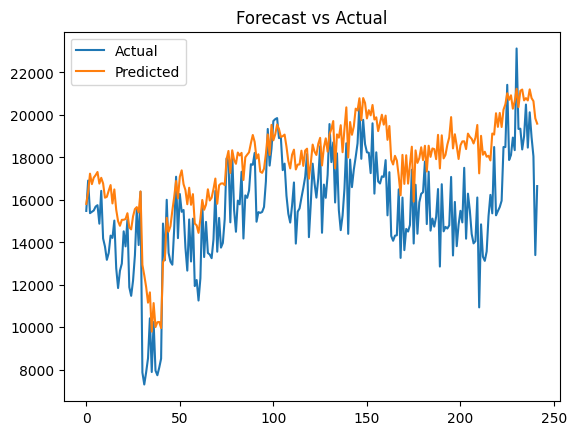

In [117]:
import matplotlib.pyplot as plt

plt.plot(y_true.flatten().numpy(), label="Actual")
plt.plot(y_pred.flatten().detach().numpy(), label="Predicted")
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

In [118]:
output = tft.predict(
    val_dataloader,
    return_x=True,
    return_index=True,
    mode="raw",
)

In [119]:
interpretation = tft.interpret_output(output[0])
attention = interpretation["attention"]

<Axes: >

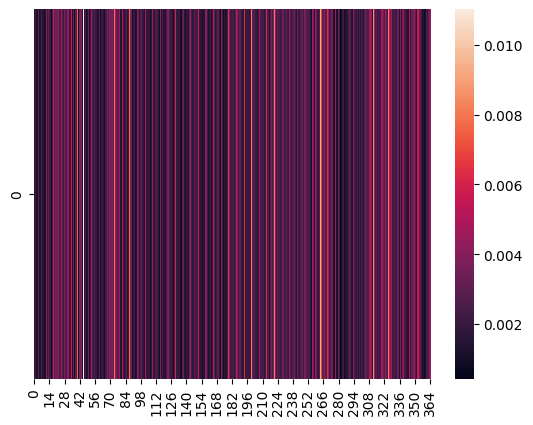

In [120]:
import seaborn as sns
sns.heatmap(attention)

## Save

In [121]:
import pickle

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

#with open(os.path.join(ROOT_DIR, "models", "model_tft.pkl"),'wb') as f:
#    pickle.dump(best_tft, f)

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [122]:
training.save(os.path.join(ROOT_DIR, "models", "tft_dataset.pkl"))

In [123]:
"""
# to load the dataset

# Cargar plantilla
template = TimeSeriesDataSet.load("tft_dataset.pkl")

# Aplicar plantilla a nuevos datos
new_dataset = TimeSeriesDataSet.from_parameters(template, new_df)

# Crear dataloader para predecir
new_dataloader = new_dataset.to_dataloader(train=False, batch_size=64)

# Hacer predicción
predictions = model.predict(new_dataloader)
"""

'\n# to load the dataset\n\n# Cargar plantilla\ntemplate = TimeSeriesDataSet.load("tft_dataset.pkl")\n\n# Aplicar plantilla a nuevos datos\nnew_dataset = TimeSeriesDataSet.from_parameters(template, new_df)\n\n# Crear dataloader para predecir\nnew_dataloader = new_dataset.to_dataloader(train=False, batch_size=64)\n\n# Hacer predicción\npredictions = model.predict(new_dataloader)\n'